# Implementacja

#### Import bibliotek

In [110]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import _tree
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from rich.tree import Tree as RichTree
from rich import print
from IPython.display import clear_output
from rich.console import Console
import json
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

#### Implementacja drzewa

In [111]:
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import clear_output
from rich.console import Console
from rich.tree import Tree as RichTree
import numpy as np


class CustomDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, similarity_threshold=0.01, preference_list=None,
                 interactive=False, interactive_threshold=0.01, random_state=None, min_samples_split=2, feature_names=None, class_names=None):
        self.max_depth = max_depth
        self.similarity_threshold = similarity_threshold
        self.preference_list = preference_list or []
        self.interactive = interactive
        self.interactive_threshold = interactive_threshold
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.tree_ = None
        self.class_names = class_names
        self.console = Console()
        self.feature_names = feature_names

    def _calculate_split_quality(self, X, y, feature_index):
        values = X[:, feature_index]
        unique_values = np.unique(values)
        splits = [y[values == val] for val in unique_values]
        weighted_gini = sum(len(s) / len(y) * (1 - sum((np.mean(s == c) ** 2 for c in np.unique(s)))) for s in splits)
        return -weighted_gini

    def _choose_split(self, qualities, highlight_path):
        best_quality = qualities[0][1]
        candidates = [q for q in qualities if abs(q[1] - best_quality) <= self.similarity_threshold]

        if self.interactive and abs(candidates[0][1] - candidates[-1][1]) <= self.interactive_threshold:
            clear_output(wait=True)
            self.console.print("[bold cyan]Tree now (> - node to insert):[/bold cyan]")
            self.console.print(self.to_rich(self.tree_, highlight_path=highlight_path))

            self.console.print("\n[bold yellow]Close quality, choose one:[/bold yellow]")

            lines = []
            for idx, (f, q) in enumerate(candidates):
                feature_name = self.feature_names[f] if self.feature_names else f"Feature {f}"
                lines.append(f"[bold blue]{idx}[/bold blue]: Feature [cyan]{feature_name}[/cyan] (Quality: [green]{q:.4f}[/green])")

            self.console.print("\n".join(lines))

            try:
                choice = int(input("Choose feature index: "))
                if choice < 0 or choice >= len(candidates):
                    print("Wrong choice, using first candidate.")
                    choice = 0
            except ValueError:
                print("Wrong input, using first candidate.")
                choice = 0
            return candidates[choice][0]

        if self.preference_list:
            candidate_features = {f for f, _ in candidates}
            for preferred in self.preference_list:
                if preferred in candidate_features:
                    return preferred

        return candidates[0][0]

    def _build_tree(self, X, y, depth=0, used_features=None, path=None, parent=None, val_from_parent=None):
        if used_features is None:
            used_features = set()
        if path is None:
            path = []

        if (self.max_depth is not None and depth >= self.max_depth) or len(set(y)) == 1 or \
        len(y) < self.min_samples_split or len(used_features) == X.shape[1]:
            leaf = {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }
            if parent is not None and val_from_parent is not None:
                parent['branches'][val_from_parent] = leaf
            return leaf
        
        qualities = [
            (i, self._calculate_split_quality(X, y, i))
            for i in range(X.shape[1]) if i not in used_features
        ]
        if not qualities:
            leaf = {
                'type': 'leaf',
                'class': np.bincount(y).argmax(),
                'label_counts': np.bincount(y, minlength=2)
            }
            if parent is not None and val_from_parent is not None:
                parent['branches'][val_from_parent] = leaf
            return leaf

        qualities.sort(key=lambda x: -x[1])
        feature = self._choose_split(qualities, path)
        new_used_features = used_features.copy()
        new_used_features.add(feature)
        default_class = np.bincount(y).argmax()

        node = {'type': 'split', 'feature': feature, 'branches': {}, 'default_class': default_class}

        if parent is not None and val_from_parent is not None:
            parent['branches'][val_from_parent] = node
        else:
            self.tree_ = node

        values = np.unique(X[:, feature])
        for val in values:
            idx = X[:, feature] == val
            if np.sum(idx) == 0:
                continue

            node['branches'][val] = {'type': 'pending'}
            if self.interactive:
                clear_output(wait=True)
                rich_tree = self.to_rich(self.tree_, highlight_path=path + [(feature, val)])
                self.console.print("[bold cyan]Tree now (> - node to insert):[/bold cyan]")
                self.console.print(rich_tree)
                self.last_rich = rich_tree

            self._build_tree(
                X[idx], y[idx],
                depth=depth + 1,
                used_features=new_used_features,
                path=path + [(feature, val)],
                parent=node,
                val_from_parent=val
            )

        if not node['branches']:
            return {
                'type': 'leaf',
                'class': default_class,
                'label_counts': np.bincount(y, minlength=2)
            }

        return node


    def fit(self, X, y):
        X_arr, y_arr = np.array(X), np.array(y)
        if self.feature_names is None:
            self.feature_names = X.columns.tolist() if hasattr(X, 'columns') else [f"Feature {i}" for i in range(X.shape[1])]
        self.tree_ = self._build_tree(X_arr, y_arr)
        clear_output(wait=True)
        return self

    def _predict_sample(self, x, node):
        if node['type'] == 'leaf':
            return node['class']
        val = x[node['feature']]
        branch = node['branches'].get(val)
        if branch is None:
            return node.get('default_class', 0)
        return self._predict_sample(x, branch)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree_) for x in X.to_numpy()])

    def predict_proba(self, X):
        def _predict_proba_sample(x, node):
            if node['type'] == 'leaf':
                counts = np.zeros(2)
                total = sum(node.get('label_counts', [0]))
                if total > 0:
                    counts[:len(node['label_counts'])] = node['label_counts']
                    return counts / total
                else:
                    return np.array([0.5, 0.5])
            val = x[node['feature']]
            branch = node['branches'].get(val)
            if branch is None:
                return np.array([0.5, 0.5])
            return _predict_proba_sample(x, branch)

        return np.array([_predict_proba_sample(x, self.tree_) for x in X.to_numpy()])

    def to_rich(self, node=None, highlight_path=None):
        if node is None:
            node = self.tree_
        if highlight_path is None:
            highlight_path = []

        def build_tree(node, path_so_far):
            if node is None:
                return RichTree("[red]No data[/red]")

            is_highlight = path_so_far == highlight_path

            if node.get('type') == 'pending':
                label = "[magenta]Building...[/magenta]"
                if is_highlight:
                    label = f"[bold red]> {label}[/bold red]"
                return RichTree(label)

            if node['type'] == 'leaf':
                cls = node['class']
                class_label = self.class_names[cls] if self.class_names else f"Class {cls}"
                label = f"[green]{class_label}[/green]"
                if is_highlight:
                    label = f"[bold red]> {label}[/bold red]"
                return RichTree(label)

            feature_name = self.feature_names[node['feature']] if self.feature_names else f"Feature {node['feature']}"
            label = f"[cyan]{feature_name}[/cyan]"
            if is_highlight:
                label = f"[bold red]> {label}[/bold red]"
            tree = RichTree(label)

            for val, child in node['branches'].items():
                new_path = path_so_far + [(node['feature'], val)]
                branch_label = f"[yellow]Value = {val}[/yellow]"
                subtree = build_tree(child, new_path)
                tree.add(branch_label).children.append(subtree)
            return tree

        return build_tree(node, [])


#### Evaluate model

In [112]:
def train_and_evaluate_model(model, X, y, target_names=None, test_size=0.2, random_state=42):
    # Data split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')
    f1_micro = f1_score(y_val, y_pred, average='micro')
    cm = confusion_matrix(y_val, y_pred)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    console = Console()
    console.print(
        f"Accuracy: {acc:.4f}\n"
        f"F1 Score (macro): {f1_macro:.4f}\n"
        f"F1 Score (micro): {f1_micro:.4f}\n"
        f"Confusion Matrix:\n{df_cm}"
    )

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC + AUC only for binary classification
    if len(np.unique(y_val)) == 2:
        y_scores = model.predict_proba(X_val)[:, 1]

        fpr, tpr, _ = roc_curve(y_val, y_scores)
        roc_auc = auc(fpr, tpr)
        
        console.print(f"AUC: {roc_auc:.4f}")
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
        plt.title("ROC Curve")
        plt.show()
    else:
        console.print("ROC + AUC only for binary classification.")
    
    metrics = {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro
    }
    return metrics, df_cm

def evaluate_model(model, X, y, target_names=None):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    cm = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
    console = Console()
    console.print(
        f"Accuracy: {acc:.4f}\n"
        f"F1 Score (macro): {f1_macro:.4f}\n"
        f"F1 Score (micro): {f1_micro:.4f}\n"
        f"Confusion Matrix:\n{df_cm}"
    )

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    metrics = {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro
    }
    return metrics, df_cm

#### Przykład wywołania (preferencje)

Accuracy: 0.9618
F1 Score (macro): 0.9618
F1 Score (micro): 0.9618
Confusion Matrix:
           edible  poisonous
edible        816         26
poisonous      36        747

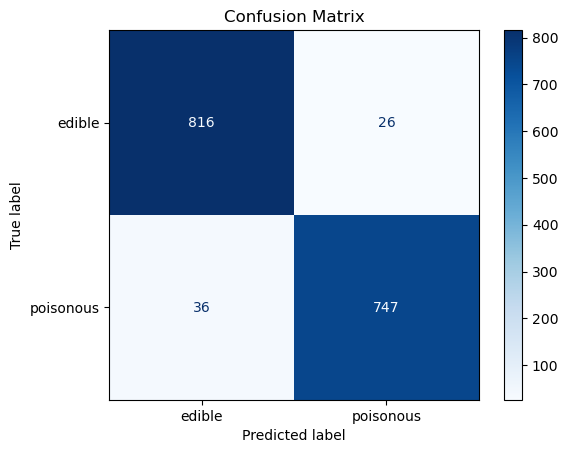

AUC: 0.9933

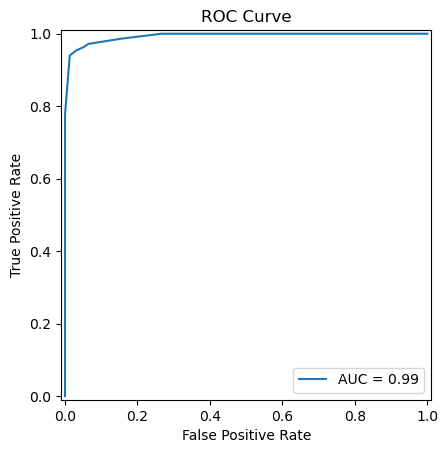

> habitat
├── Value = 0
│   └── population
│       ├── Value = 1
│       │   └── poisonous
│       ├── Value = 3
│       │   └── poisonous
│       ├── Value = 4
│       │   └── spore-print-color
│       │       ├── Value = 1
│       │       │   └── ring-type
│       │       │       ├── Value = 1
│       │       │       │   └── edible
│       │       │       └── Value = 2
│       │       │           └── poisonous
│       │       ├── Value = 2
│       │       │   └── ring-type
│       │       │       └── Value = 4
│       │       │           └── edible
│       │       ├── Value = 3
│       │       │   └── ring-type
│       │       │       └── Value = 4
│       │       │           └── edible
│       │       ├── Value = 6
│       │       │   └── edible
│       │       └── Value = 7
│       │           └── poisonous
│       └── Value = 5
│           └── spore-print-color
│               ├── Value = 1
│               │   └── ring-type
│               │       ├── Value = 1
│               │       │   └── edible
│               │       └── Value = 2
│               │           └── poisonous
│               ├── Value = 2
│               │   └── edible
│               ├── Value = 3
│               │   └── edible
│               └── Value = 7
│                   └── edible
├── Value = 1
│   └── population
│       ├── Value = 0
│       │   └── edible
│       ├── Value = 2
│       │   └── edible
│       ├── Value = 3
│       │   └── spore-print-color
│       │       ├── Value = 1
│       │       │   └── poisonous
│       │       ├── Value = 2
│       │       │   └── ring-type
│       │       │       ├── Value = 0
│       │       │       │   └── edible
│       │       │       └── Value = 4
│       │       │           └── edible
│       │       ├── Value = 3
│       │       │   └── ring-type
│       │       │       ├── Value = 0
│       │       │       │   └── edible
│       │       │       └── Value = 4
│       │       │           └── edible
│       │       └── Value = 7
│       │           └── edible
│       ├── Value = 4
│       │   └── poisonous
│       └── Value = 5
│           └── spore-print-color
│               ├── Value = 1
│               │   └── poisonous
│               ├── Value = 2
│               │   └── edible
│               └── Value = 3
│                   └── edible
├── Value = 2
│   └── population
│       ├── Value = 1
│       │   └── spore-print-color
│       │       ├── Value = 0
│       │       │   └── edible
│       │       ├── Value = 3
│       │       │   └── edible
│       │       ├── Value = 4
│       │       │   └── edible
│       │       ├── Value = 7
│       │       │   └── poisonous
│       │       └── Value = 8
│       │           └── edible
│       └── Value = 4
│           └── spore-print-color
│               ├── Value = 0
│               │   └── edible
│               ├── Value = 3
│               │   └── edible
│               ├── Value = 4
│               │   └── edible
│               ├── Value = 7
│               │   └── ring-type
│               │       └── Value = 0
│               │           └── poisonous
│               └── Value = 8
│                   └── edible
├── Value = 3
│   └── population
│       ├── Value = 2
│       │   └── edible
│       ├── Value = 3
│       │   └── edible
│       └── Value = 4
│           └── poisonous
├── Value = 4
│   └── population
│       ├── Value = 3
│       │   └── edible
│       ├── Value = 4
│       │   └── spore-print-color
│       │       ├── Value = 1
│       │       │   └── poisonous
│       │       └── Value = 7
│       │           └── ring-type
│       │               ├── Value = 0
│       │               │   └── poisonous
│       │               └── Value = 4
│       │                   └── edible
│       └── Value = 5
│           └── spore-print-color
│               ├── Value = 1
│               │   └── poisonous
│               ├── Value = 2
│               │   └── edible
│               ├── Value = 3
│               │   └── edible
│             

In [113]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5, class_names=["edible", "poisonous"])
                                   
train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=3928, target_names=["edible", "poisonous"])
console = Console()
console.print(clf.to_rich())


#### Przykład wywołania (interaktywny)

Accuracy: 0.9729
F1 Score (macro): 0.9729
F1 Score (micro): 0.9729
Confusion Matrix:
           edible  poisonous
edible        829         13
poisonous      31        752

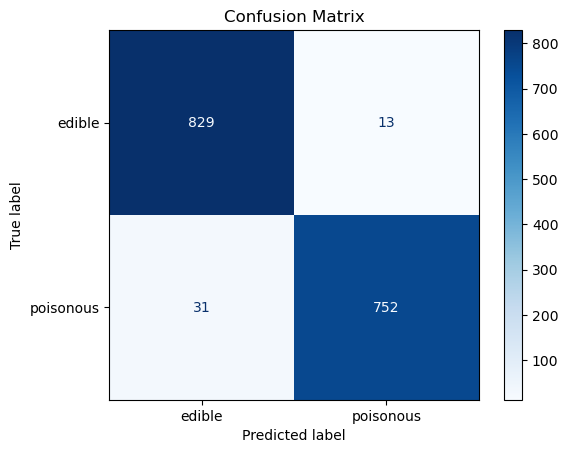

> habitat
├── Value = 0
│   └── population
│       ├── Value = 1
│       │   └── Class 1
│       ├── Value = 3
│       │   └── Class 1
│       ├── Value = 4
│       │   └── spore-print-color
│       │       ├── Value = 1
│       │       │   └── ring-type
│       │       │       ├── Value = 1
│       │       │       │   └── Class 0
│       │       │       └── Value = 2
│       │       │           └── Class 1
│       │       ├── Value = 2
│       │       │   └── ring-type
│       │       │       └── Value = 4
│       │       │           └── Class 0
│       │       ├── Value = 3
│       │       │   └── ring-type
│       │       │       └── Value = 4
│       │       │           └── Class 0
│       │       ├── Value = 6
│       │       │   └── Class 0
│       │       └── Value = 7
│       │           └── Class 1
│       └── Value = 5
│           └── spore-print-color
│               ├── Value = 1
│               │   └── ring-type
│               │       ├── Value = 1
│               │       │   └── Class 0
│               │       └── Value = 2
│               │           └── Class 1
│               ├── Value = 2
│               │   └── Class 0
│               ├── Value = 3
│               │   └── Class 0
│               └── Value = 7
│                   └── Class 0
├── Value = 1
│   └── population
│       ├── Value = 0
│       │   └── Class 0
│       ├── Value = 2
│       │   └── Class 0
│       ├── Value = 3
│       │   └── spore-print-color
│       │       ├── Value = 1
│       │       │   └── Class 1
│       │       ├── Value = 2
│       │       │   └── ring-type
│       │       │       ├── Value = 0
│       │       │       │   └── Class 0
│       │       │       └── Value = 4
│       │       │           └── Class 0
│       │       ├── Value = 3
│       │       │   └── ring-type
│       │       │       ├── Value = 0
│       │       │       │   └── Class 0
│       │       │       └── Value = 4
│       │       │           └── Class 0
│       │       └── Value = 7
│       │           └── Class 0
│       ├── Value = 4
│       │   └── Class 1
│       └── Value = 5
│           └── spore-print-color
│               ├── Value = 1
│               │   └── Class 1
│               ├── Value = 2
│               │   └── Class 0
│               └── Value = 3
│                   └── Class 0
├── Value = 2
│   └── population
│       ├── Value = 1
│       │   └── spore-print-color
│       │       ├── Value = 0
│       │       │   └── Class 0
│       │       ├── Value = 3
│       │       │   └── Class 0
│       │       ├── Value = 4
│       │       │   └── Class 0
│       │       ├── Value = 7
│       │       │   └── Class 1
│       │       └── Value = 8
│       │           └── Class 0
│       └── Value = 4
│           └── spore-print-color
│               ├── Value = 0
│               │   └── Class 0
│               ├── Value = 3
│               │   └── Class 0
│               ├── Value = 4
│               │   └── Class 0
│               ├── Value = 7
│               │   └── odor
│               │       ├── Value = 2
│               │       │   └── Class 1
│               │       ├── Value = 5
│               │       │   └── Class 0
│               │       ├── Value = 7
│               │       │   └── Class 1
│               │       └── Value = 8
│               │           └── Class 1
│               └── Value = 8
│                   └── Class 0
├── Value = 3
│   └── population
│       ├── Value = 2
│       │   └── Class 0
│       ├── Value = 3
│       │   └── Class 0
│       └── Value = 4
│           └── Class 1
├── Value = 4
│   └── population
│       ├── Value = 3
│       │   └── Class 0
│       ├── Value = 4
│       │   └── bruises%3F
│       │       ├── Value = 0
│       │       │   └── Class 1
│       │       └── Value = 1
│       │           └── Class 0
│       └── Value = 5
│           └── spore-print-color
│               ├── Value = 1
│               │   └── Class 1
│               ├── Value = 2
│               │   └── Class 0
│        

In [ ]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=3131, stratify=y
)
feature_order = list(range(X.shape[1]))
clf = CustomDecisionTreeClassifier(preference_list=feature_order[::-1],
                                   similarity_threshold=0.5,
                                   max_depth=4,
                                   min_samples_split=5,
                                   interactive=True,
                                   interactive_threshold=0.25)
clf.fit(X_train, y_train)
evaluate_model(clf, X_val, y_val, target_names=["edible", "poisonous"])
console = Console()
console.print(clf.to_rich())

# Testy i eksperymenty

## Zbiory danych

In [115]:
metrics = {}

### Mushroom

In [116]:
data = fetch_openml(name="mushroom", version=1, as_frame=True)
X = data.data
y = data.target

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)
metrics["Mushroom"] = {}
RANDOM_STATE = 3928

#### 0) Podstawowy klasyfikator (brak preferencji)


Accuracy: 1.0000
F1 Score (macro): 1.0000
F1 Score (micro): 1.0000
Confusion Matrix:
           edible  poisonous
edible        842          0
poisonous       0        783

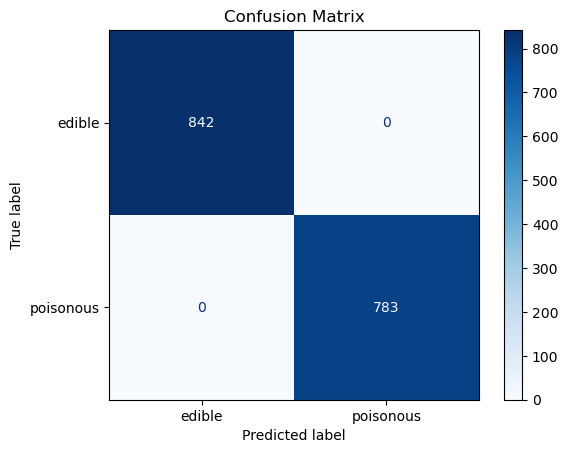

AUC: 1.0000

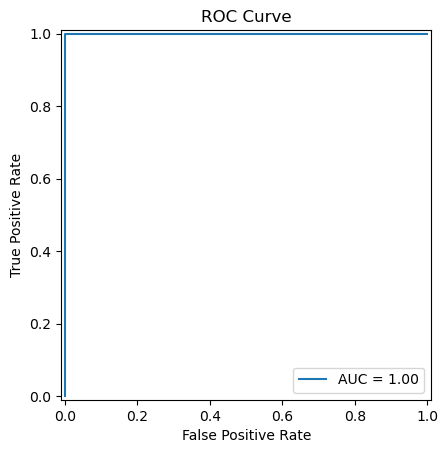

In [117]:
clf = CustomDecisionTreeClassifier(
    preference_list=[],
    similarity_threshold=0.0,
    max_depth=5,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["0"] = (met, cm)

#### a) Preferowane atrybuty o niewielkiej liczbie wartości

Accuracy: 0.8917
F1 Score (macro): 0.8908
F1 Score (micro): 0.8917
Confusion Matrix:
           edible  poisonous
edible        799         43
poisonous     133        650

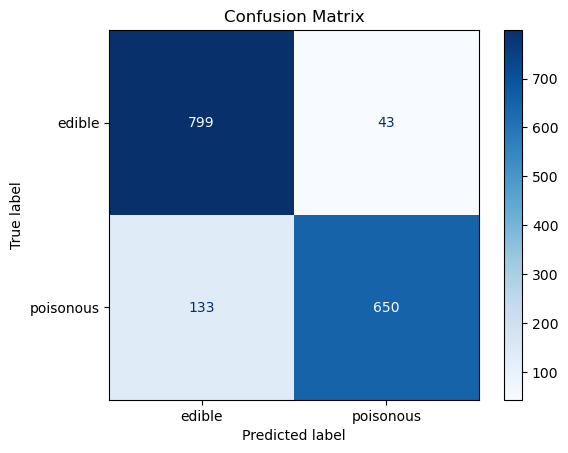

AUC: 0.9062

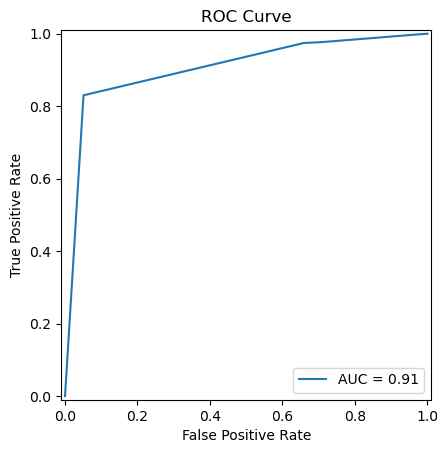

Feature order:
[15, 3, 5, 6, 7, 9, 17, 1, 16, 11, 12, 10, 18, 0, 20, 21, 14, 4, 19, 13, 2, 8]

In [118]:
feature_cardinality = X.nunique()
sorted_features = feature_cardinality.sort_values().index.tolist()
feature_order = [X.columns.get_loc(col) for col in sorted_features]

clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["a"] = (met, cm)
print("Feature order:", feature_order)

#### b) Preferowane atrybuty ustalone przez analizę danych

Accuracy: 0.9938
F1 Score (macro): 0.9938
F1 Score (micro): 0.9938
Confusion Matrix:
           edible  poisonous
edible        842          0
poisonous      10        773

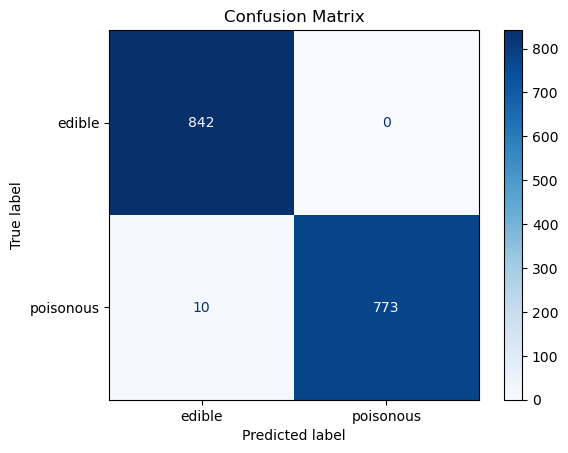

AUC: 0.9998

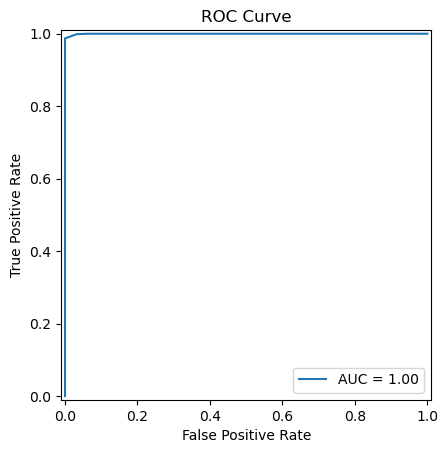

Feature order:
[4, 19, 8, 18, 11, 12, 13, 14, 7, 3, 20, 21, 10, 6, 0, 17, 1, 2, 16, 5, 9, 15]

In [119]:
from sklearn.feature_selection import mutual_info_classif
mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}

sorted_features = sorted(feature_scores.items(), key=lambda x: -x[1])
feature_order_b = [X.columns.get_loc(col) for col, _ in sorted_features]

clf_b = CustomDecisionTreeClassifier(
    preference_list=feature_order_b,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)

met_b, cm_b = train_and_evaluate_model(clf_b, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["b"] = (met_b, cm_b)
print("Feature order:", feature_order_b)

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

Accuracy: 0.9945
F1 Score (macro): 0.9945
F1 Score (micro): 0.9945
Confusion Matrix:
           edible  poisonous
edible        841          1
poisonous       8        775

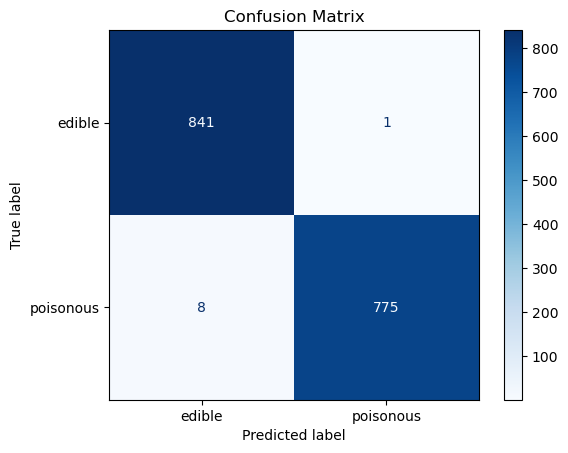

AUC: 0.9999

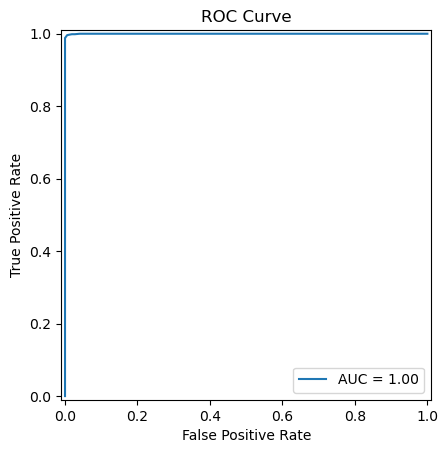

Feature order:
[4, 2, 7, 8]

In [120]:
preferred_features = ['odor', 'cap-color', 'gill-size', 'gill-color']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["c"] = (met, cm)
print("Feature order:", feature_order)

#### d) Unikanie atrybutów zawierających szum

Accuracy: 0.9065
F1 Score (macro): 0.9064
F1 Score (micro): 0.9065
Confusion Matrix:
           edible  poisonous
edible        750         92
poisonous      60        723

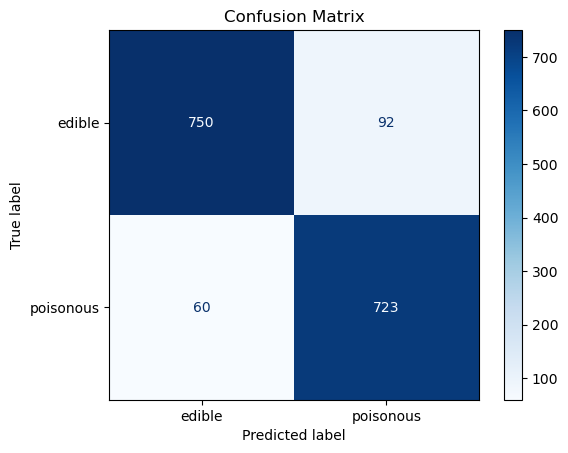

AUC: 0.9362

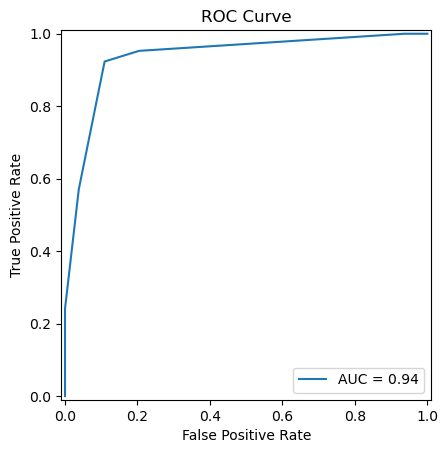

Filtered feature order (noise-avoiding):
[4, 19, 8, 18, 11, 12, 13, 14, 7, 3, 20, 21, 10, 6, 0, 17, 1, 2, 16, 5]

In [121]:
from sklearn.feature_selection import mutual_info_classif

mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}

threshold = 0.01 

filtered_features = [(col, score) for col, score in feature_scores.items() if score > threshold]
feature_order_c = [X.columns.get_loc(col) for col, _ in sorted(filtered_features, key=lambda x: -x[1])]

clf_d = CustomDecisionTreeClassifier(
    preference_list=feature_order_c,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)

met_d, cm_d = train_and_evaluate_model(clf_d, X.iloc[:, feature_order_c], y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["d"] = (met_d, cm_d)

print("Filtered feature order (noise-avoiding):", feature_order_c)

#### e) Preferencje na podstawie logicznej istotności

Accuracy: 0.9969
F1 Score (macro): 0.9969
F1 Score (micro): 0.9969
Confusion Matrix:
           edible  poisonous
edible        839          3
poisonous       2        781

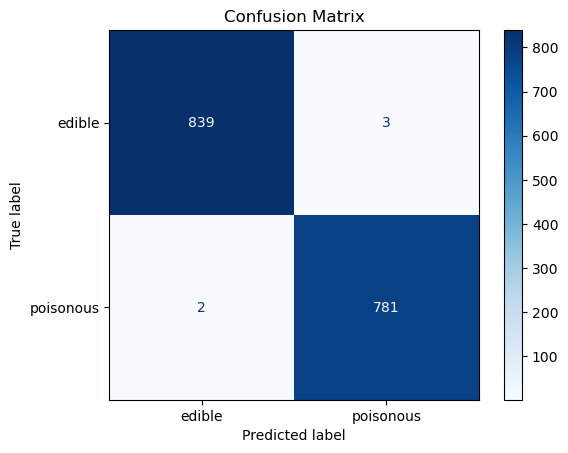

AUC: 1.0000

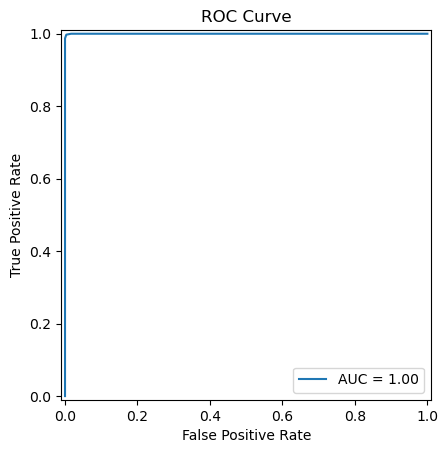

Feature order:
[4, 19, 8]

In [122]:
preferred_features = ['odor', 'spore-print-color', 'gill-color']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=4,
    min_samples_split=5,
    class_names=["edible", "poisonous"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["edible", "poisonous"])
metrics["Mushroom"]["e"] = (met, cm)
print("Feature order:", feature_order)

#### Porównanie podejść

In [127]:
rows = []
for key in metrics["Mushroom"]:
    scores, cm = metrics["Mushroom"][key]
    fn = cm.loc["edible", "poisonous"]
    fp = cm.loc["poisonous", "edible"]
    total_errors = fn + fp
    rows.append({
        "Experiment": key,
        "Accuracy": round(scores["accuracy"], 4),
        "F1 Macro": round(scores["f1_macro"], 4),
        "F1 Micro": round(scores["f1_micro"], 4),
        "Total errors (FP+FN)": total_errors
    })

df = pd.DataFrame(rows).sort_values(by="Experiment")
print(df.to_string(index=False))

Experiment  Accuracy  F1 Macro  F1 Micro  Total errors (FP+FN)
         0    1.0000    1.0000    1.0000                     0
         a    0.8917    0.8908    0.8917                   176
         b    0.9938    0.9938    0.9938                    10
         c    0.9945    0.9945    0.9945                     9
         d    0.9065    0.9064    0.9065                   152
         e    0.9969    0.9969    0.9969                     5

### Wine Quality

In [128]:
data = fetch_openml(name="wine-quality-red", version=1, as_frame=True)
X = data.data
y = data.target.astype(int)

# Binarna klasyfikacja: dobre (>=6), złe (<6)
y = (y >= 6).astype(int)
X = X.copy()
metrics["Wine"] = {}
RANDOM_STATE = 3928

#### 0) Podstawowy klasyfikator (brak preferencji)


Accuracy: 0.6625
F1 Score (macro): 0.6614
F1 Score (micro): 0.6625
Confusion Matrix:
      bad  good
bad    97    52
good   56   115

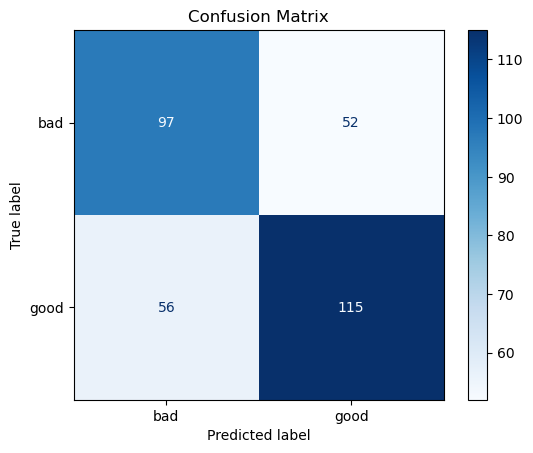

AUC: 0.7275

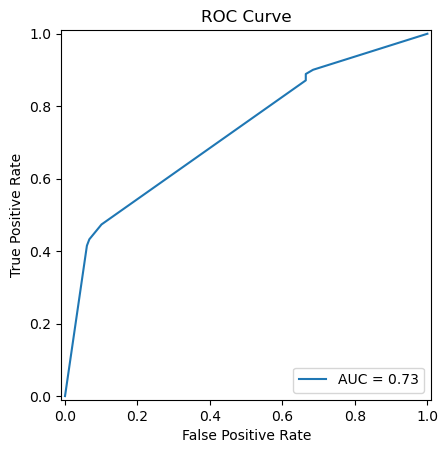

In [129]:
clf = CustomDecisionTreeClassifier(
    preference_list=[],
    similarity_threshold=0.0,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["0"] = (met, cm)

#### a) Preferowane atrybuty o niewielkiej liczbie wartości

Accuracy: 0.6625
F1 Score (macro): 0.6624
F1 Score (micro): 0.6625
Confusion Matrix:
      bad  good
bad   104    45
good   63   108

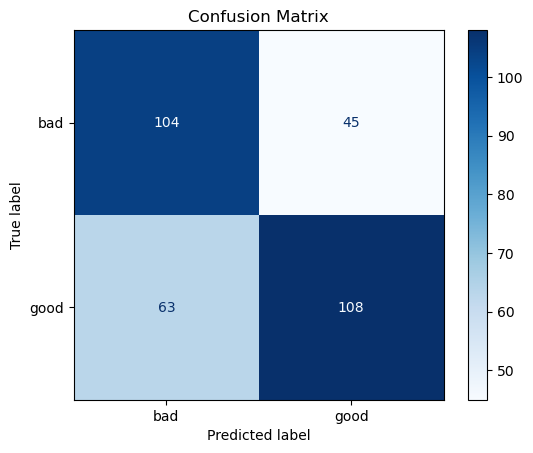

AUC: 0.7144

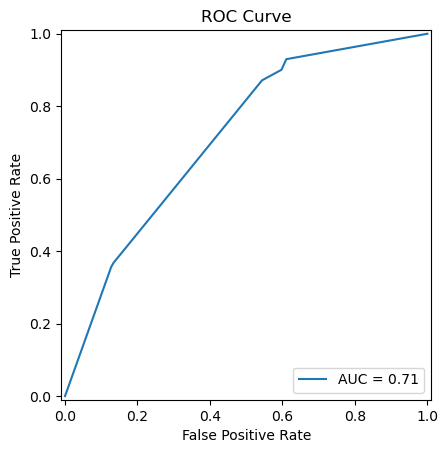

Feature order:
[5, 10, 2, 8, 3, 0, 9, 1, 6, 4, 7]

In [130]:
feature_cardinality = X.nunique()
sorted_features = feature_cardinality.sort_values().index.tolist()
feature_order = [X.columns.get_loc(col) for col in sorted_features]

clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["a"] = (met, cm)
print("Feature order:", feature_order)

#### b) Preferowane atrybuty ustalone przez analizę danych

Accuracy: 0.7656
F1 Score (macro): 0.7634
F1 Score (micro): 0.7656
Confusion Matrix:
      bad  good
bad   107    42
good   33   138

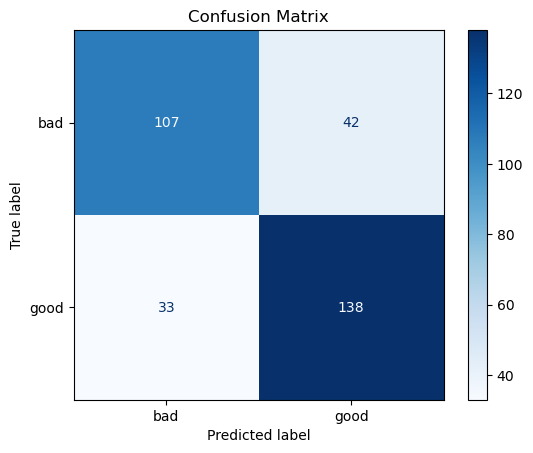

AUC: 0.7719

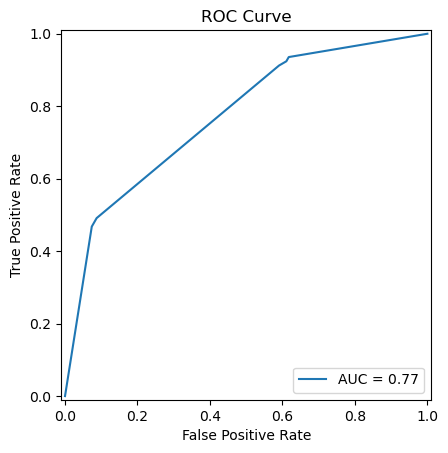

Feature order:
[10, 1, 6, 9, 7, 2, 0, 4, 3, 8, 5]

In [131]:
mutual_info = mutual_info_classif(X, y, random_state=RANDOM_STATE)
feature_scores = {X.columns[i]: mi for i, mi in enumerate(mutual_info)}
sorted_features = sorted(feature_scores.items(), key=lambda x: -x[1])
feature_order_b = [X.columns.get_loc(col) for col, _ in sorted_features]

clf_b = CustomDecisionTreeClassifier(
    preference_list=feature_order_b,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met_b, cm_b = train_and_evaluate_model(clf_b, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["b"] = (met_b, cm_b)
print("Feature order:", feature_order_b)

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

Accuracy: 0.6406
F1 Score (macro): 0.6405
F1 Score (micro): 0.6406
Confusion Matrix:
      bad  good
bad   100    49
good   66   105

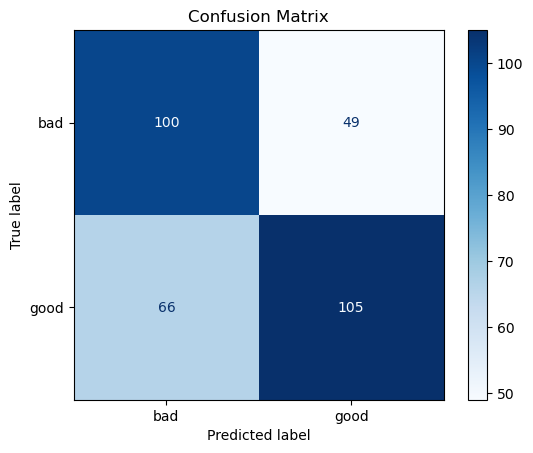

AUC: 0.6832

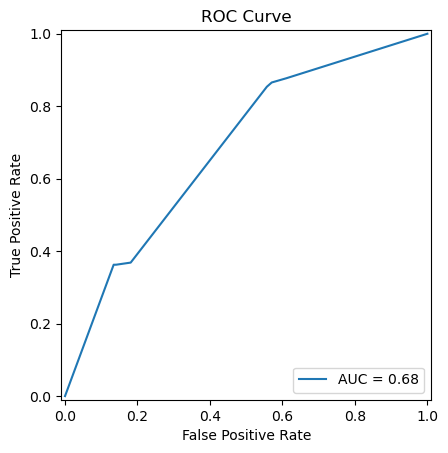

Feature order:
[8, 10, 9]

In [132]:
preferred_features = ['pH', 'alcohol', 'sulphates']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["c"] = (met, cm)
print("Feature order:", feature_order)

#### d) Unikanie atrybutów zawierających szum

Accuracy: 0.6406
F1 Score (macro): 0.6384
F1 Score (micro): 0.6406
Confusion Matrix:
      bad  good
bad    90    59
good   56   115

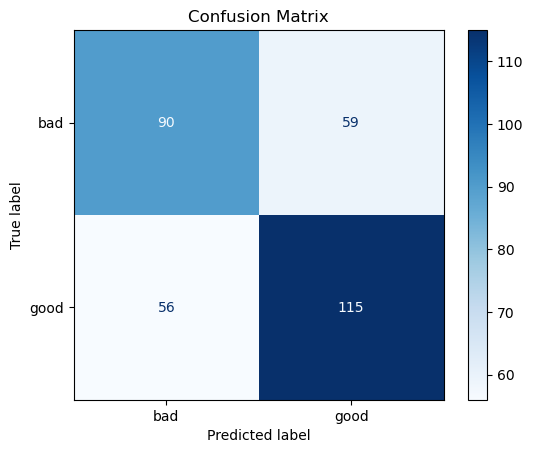

AUC: 0.7037

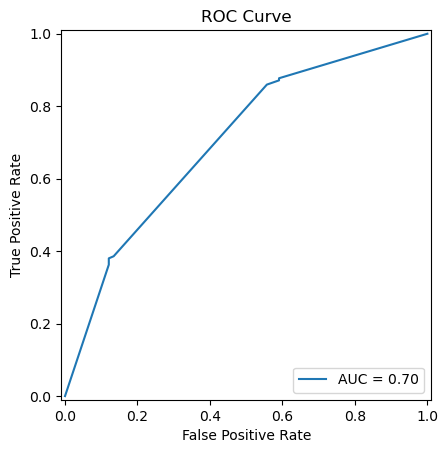

Filtered feature order (noise-avoiding):
[10, 1, 6, 9, 7, 2, 0, 4, 3]

In [138]:
threshold = 0.01
filtered_features = [(col, score) for col, score in feature_scores.items() if score > threshold]
feature_order_d = [X.columns.get_loc(col) for col, _ in sorted(filtered_features, key=lambda x: -x[1])]

clf_d = CustomDecisionTreeClassifier(
    preference_list=feature_order_d,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met_d, cm_d = train_and_evaluate_model(clf_d, X.iloc[:, feature_order_d], y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["d"] = (met_d, cm_d)
print("Filtered feature order (noise-avoiding):", feature_order_d)

#### e) Preferencje na podstawie logicznej istotności

Accuracy: 0.7656
F1 Score (macro): 0.7634
F1 Score (micro): 0.7656
Confusion Matrix:
      bad  good
bad   107    42
good   33   138

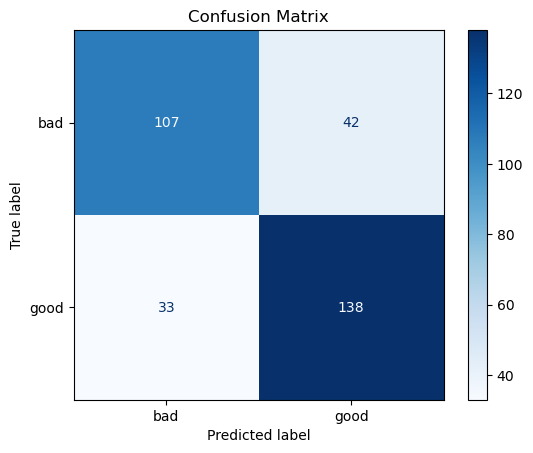

AUC: 0.7719

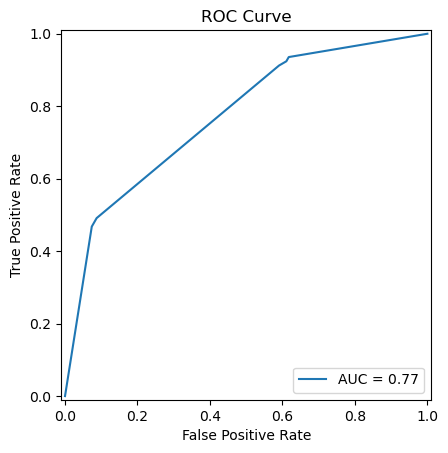

Feature order:
[10, 1, 7]

In [139]:
preferred_features = ['alcohol', 'volatile_acidity', 'density']
feature_order = [X.columns.get_loc(col) for col in preferred_features]
clf = CustomDecisionTreeClassifier(
    preference_list=feature_order,
    similarity_threshold=0.5,
    max_depth=5,
    min_samples_split=5,
    class_names=["bad", "good"]
)
met, cm = train_and_evaluate_model(clf, X, y, test_size=0.2, random_state=RANDOM_STATE, target_names=["bad", "good"])
metrics["Wine"]["e"] = (met, cm)
print("Feature order:", feature_order)

#### Porównanie podejść

In [140]:
rows = []
for key in metrics["Wine"]:
    scores, cm = metrics["Wine"][key]
    fn = cm.loc["good", "bad"]
    fp = cm.loc["bad", "good"]
    total_errors = fn + fp
    rows.append({
        "Experiment": key,
        "Accuracy": round(scores["accuracy"], 4),
        "F1 Macro": round(scores["f1_macro"], 4),
        "F1 Micro": round(scores["f1_micro"], 4),
        "Total errors (FP+FN)": total_errors
    })

df = pd.DataFrame(rows).sort_values(by="Experiment")
print(df.to_string(index=False))

Experiment  Accuracy  F1 Macro  F1 Micro  Total errors (FP+FN)
         0    0.6625    0.6614    0.6625                   108
         a    0.6625    0.6624    0.6625                   108
         b    0.7656    0.7634    0.7656                    75
         c    0.6406    0.6405    0.6406                   115
         d    0.6406    0.6384    0.6406                   115
         e    0.7656    0.7634    0.7656                    75

### Apartment for Rent Classified

#### 0) Podstawowy klasyfikator (brak preferencji)


#### a) Preferowane atrybuty o niewielkiej liczbie wartości

#### b) Preferowane atrybuty ustalone przez analizę danych

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

#### d) Unikanie atrybutów zawierających szum

#### e) Preferencje na podstawie logicznej istotności

#### Porównanie podejść

### Appliances Energy Prediction

#### 0) Podstawowy klasyfikator (brak preferencji)


#### a) Preferowane atrybuty o niewielkiej liczbie wartości

#### b) Preferowane atrybuty ustalone przez analizę danych

#### c) Preferowane atrybuty na podstawie kosztu uzyskania (w domyśle)

#### d) Unikanie atrybutów zawierających szum

#### e) Preferencje na podstawie logicznej istotności

#### Porównanie podejść

## Porównanie wszystkich podejść

## Wnioski